# Using Convolutional Neural Networks (CNNs) to Classify Digits

## CNN Background

Convolutional neural networks (CNNs) are kinds of neural networks that are useful in computer vision.

There are four main operations in a CNN (adapted from <i><a href="https://ujjwalkarn.me/2016/08/11/intuitive-explanation-convnets/">An Intuitive Explanation of Convolutional Neural Networks</a></i>):

- Convolution
    - Convolution preserves spatial data between pixels and learns image features by "convolving" filters across an image. We slide the filter over the original image by our stride and compute an element wise multiplication. We add the output to the corresponding index of the feature map. In this sense, filters act as "feature detectors" in images.
    - Different filters can produce different feature maps and help in operations such as edge detection, blur, and sharpening.
    - In practice, the CNN learns the values of filters during the training process. However, a human still much specify parameters such as the # of filters, filter size, etc. Generally, the more filters we have, the more image features we can extract and the better the system becomes when classifying unseen images.
    - The size of a feature map is controlled by depth (# of filters; this creates a "volume"), stride (# of pixels we slide the filter matrix over the input matrix), and zero-padding (padding the input matrix with zeroes on the border so we can apply the filter to bordering elements).
    
- Non-linearity
    - After every convolution operation, a non-linear operation (such as ReLU) is applied. This introduces non-linearity and helps our model become more complex.
    
- Pooling
    - Pooling, or downsampling, reduces the dimensionality of the feature map but retains important information. Max pooling takes the largest element from the feature map within that window. After pooling, we are left with a reduced spatial size of the input representation.
    
- Classification 
    - A fully-connected layer acts as a classifier. The output from the previous convolution and pooling layers represent high-level features of the input image. We use a fully-connecting layer (every neuron in the previous layer is connected to every neuron on the left layer) to use these features for classifying the input image into various classes based on the training dataset. Then backpropogation is used to minimize the output error.

To summarize:

1) We initialize all filters and parameters / weights with random values

2) The network takes a training image as input, goes through the forward propagation step (convolution, ReLU and pooling operations along with forward propagation in the Fully Connected layer) and finds the output probabilities for each class. Since weights are randomly assigned for the first training example, output probabilities are also random.

3) Calculate the total error at the output layer

4) Use Backpropagation to calculate the gradients of the error with respect to all weights in the network and use gradient descent to update all filter values / weights and parameter values to minimize the output error. The weights are adjusted in proportion to their contribution to the total error. Parameters like number of filters, filter sizes, architecture of the network etc. have all been fixed before Step 1 and do not change during training process – only the values of the filter matrix and connection weights get updated.

5) Repeat steps 2-4 with all images in the training set.

<hr>

## Classifying Digits with CNNs

I will be using the famous <a href="https://www.kaggle.com/c/digit-recognizer">MNIST dataset</a> to develop a CNN to classifying digits. According to its Kaggle page:

<i> MNIST ("Modified National Institute of Standards and Technology") is the de facto “hello world” dataset of computer vision. Since its release in 1999, this classic dataset of handwritten images has served as the basis for benchmarking classification algorithms. As new machine learning techniques emerge, MNIST remains a reliable resource for researchers and learners alike. </i>

My model below is based off of Jason Brownley's model in [*How to Develop a CNN for MNIST Handwritten Digit Classification*](https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-from-scratch-for-mnist-handwritten-digit-classification/).


## Loading in Libraries

In [12]:
from numpy import mean
from numpy import std
from matplotlib import pyplot
from sklearn.model_selection import KFold
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD

## Developing Loading Function

We already know that the MNIST dataset has square images of 28 x 28 pixels, and that the images are greyscale. So, we only have to reshape the data as well as one hot encode target values in the Y set.

In [13]:
def load_dataset():
	# load dataset
	(trainX, trainY), (testX, testY) = mnist.load_data()
 
	# reshape dataset to have a single canal (grayscale images have 1, RGB have 3)
	trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
	testX = testX.reshape((testX.shape[0], 28, 28, 1))
 
	# one hot encode target values
	trainY = to_categorical(trainY)
	testY = to_categorical(testY)
	return trainX, trainY, testX, testY

## Preprocessing Pixels

Pixel values for each image are integers between black and white, or 0 and 255. We normalize our values to 0-1 by dividing each value by 255. This improves model performance.

In [14]:
def prep_pixels(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm

## Define Model

This is where we can define and easily modify our model architecture. We use the Keras `Sequential()` function to define the CNN. We use an input shape of (28, 28, 1) and a filter size of 3x3 along with 40 filters. We will then pool, flatten our values, and enter the fully connected layers, where we will have a dense layer with 100 nodes outputting into an output layer with 10 nodes. We will then compile the model with `adam` and a loss of categorical cross entropy.We will use the `ReLU` activation function, but use `softmax` for the output layer.

In [15]:
def define_model():
	model = Sequential()
	model.add(Conv2D(40, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(10, activation='softmax'))
	# compile model
	model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
	return model

## Evaluate the Model Using k-fold Cross Validation

After we define the model, we should evaluate it. We can use the method of k-fold cross validation with a k = 5. Thus, each test set will be 20% of the training dataset. We will use 10 epochs and a batch size of 50. In each "fold", we will develop a new model using a different subset of the training data and test data. We'll save the scores and histories to return and see which model performed best, as well as the general accuracy of the model.

In [16]:
def evaluate_model(dataX, dataY, n_folds=5):
	scores, histories = list(), list()
	# prepare cross validation
	kfold = KFold(n_folds, shuffle=True, random_state=1)
	# enumerate splits
	for train_ix, test_ix in kfold.split(dataX):
		# define model
		model = define_model()
		# select rows for train and test
		trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
		# fit model
		history = model.fit(trainX, trainY, epochs=10, batch_size=50, validation_data=(testX, testY), verbose=0)
		# evaluate model
		_, acc = model.evaluate(testX, testY, verbose=0)
		print('> %.3f' % (acc * 100.0))
		# stores scores
		scores.append(acc)
		histories.append(history)
	return scores, histories

## Displaying Results

We can plot diagnostic learning curves to display the results. We need to display two key things:

- Diagnostics of the learning behavior of the model during training
- Estimation of the model performance

We can create a line plot showing model performance on the train and test set during each fold. We can get an idea at whether the model is overfitting or underfitting, if it is.

Then, we can create a figure with two subplots to display loss and then accuracy. 

In [61]:
def summarize_diagnostics(histories):
	for i in range(len(histories)):
		# plot loss
		pyplot.subplot(2, 1, 1)
		pyplot.title('Cross Entropy Loss')
		pyplot.plot(histories[i].history['loss'], color='blue', label='train')
		pyplot.plot(histories[i].history['val_loss'], color='orange', label='test')
    
		# plot accuracy
		pyplot.subplot(2, 1, 2)
		pyplot.title('Classification Accuracy')
		pyplot.plot(histories[i].history['accuracy'], color='blue', label='train')
		pyplot.plot(histories[i].history['val_accuracy'], color='orange', label='test')
  
pyplot.show()

IndentationError: ignored

## Summarizing Model Performance

We can summarize the accuracy in general of the model by printing out the mean and standard deviation of the accuracies across folds. We can also visualize the distribution of scores using a box and whisker plot.

In [18]:
def summarize_performance(scores):
	# print summary
	print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
	# box and whisker plots of results
	pyplot.boxplot(scores)
	pyplot.show()

## Running the Functions

We can define a test harness below for loading in the data, preprocessing, evaluation, plotting learning curves, and summarizing estimated performance.

In [19]:
# run the test harness for evaluating a model
def run_test_harness():
	# load dataset
	trainX, trainY, testX, testY = load_dataset()
	# prepare pixel data
	trainX, testX = prep_pixels(trainX, testX)
	# evaluate model
	scores, histories = evaluate_model(trainX, trainY)
	# learning curves
	summarize_diagnostics(histories)
	# summarize estimated performance
	summarize_performance(scores)

> 98.383
> 98.408
> 98.450
> 98.625
> 98.667
Accuracy: mean=98.507 std=0.116, n=5


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


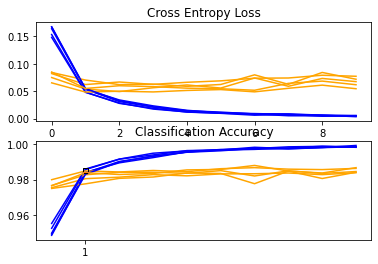

In [46]:
# entry point, run the test harness
run_test_harness()

We can see that the model tends to achieve a good fit, as the train and test curves converge. We also see that the mean model performance was approx 98.5%.

## Approaches to Improving the Model

The first, and often biggest, thing we can do to improve a model is change the learning rate. We can also accelerate the learning of the model by using batch normalization. 

Batch normalization can be used after the convolutional and fully connected layers. It changes the distribution of the output of the layer by standardizing the outputs and can speed up learning.

Another method is increasing model depth. Two common approaches involve:

- Changing capacity of the feature extraction portion of the model
  - This is often more influential. We can add more convolutional and pooling layers we the same sized filter, while increasing the number of filters. Each layer will be followed by another max pooling layer.
- Changing capacity or function of the classifier part of the model